In [1]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plt

# Turn-on all warnings into errors
np.seterr(all="raise")

# Connect to the database and define a cursor
conn = sqlite3.connect('../results.db')
c = conn.cursor()

In [2]:
# Set parameters for matplotlib
plt.rcParams.update({'font.size': 14})
colors = ['#d73027', '#f46d43', '#aaaaaa', '#66bd63', '#1a9850']

In [3]:
# Get all the relevant data
MOLECULES = [name for (name,) in c.execute("""SELECT name FROM molecule""").fetchall()]
HGRIDS = [value for (value,) in c.execute("""SELECT value FROM hgrid""").fetchall()][::-1]
RMULTS = c.execute("""SELECT frmult, crmult FROM rmult""").fetchall()
nb_notebooks = c.execute("SELECT COUNT(*) FROM notebook").fetchall()[0][0]
xmax = nb_notebooks // len(MOLECULES)

In [4]:
# Be sure to run the post_processing.ipynb notebook to make sure the
# converged_param table is in the database.
data = c.execute("""SELECT * FROM converged_param""").fetchall()
CONVERGED_PARAMS = {
    name: {"hgrids": hg, "rmult": [frm, crm]}
    for (name, hg, frm, crm) in data
}
# Looking at the convergence data, one suspects that the correct
# values for hgrids should be 0.38 for the CH4 molecule
CONVERGED_PARAMS["CH4"]["hgrids"] = 0.38

## Total energies convergence for each molecule

In each plot below, which focuses on one particular molecule, each phonon energy is represented by one point. A given column accounts for the phonons found for one particular set of input parameters. The five first columns represent the phonons for the highest hgrid, sorted by increasing rmult from left to right. It goes on like this by packet of five columns until the last five columns, which represent the phonons for the lowest hgrid. The rightmost column represents the most converged phonon energies: it corresponds to computations with the smallest grid-step (hgrid) and the largest grid extension (rmult).

In [6]:
try:
    # Put all the relevant BigDFT data in a single temprary table
    c.execute("CREATE TEMP TABLE total_energies AS "
              "SELECT n.id, n.hgrid, e.value, n.molecule, n.crmult, n.frmult "
              "FROM total_energy e "
              "JOIN notebook n ON n.id = e.id_notebook")
except sqlite3.OperationalError:
    pass

In [7]:
def plot_total_energies(name, only_converged=False, save_file=None):
    """
    Plot the total energies of a given molecule. You can
    specifically filter the energies by selecting those coming 
    from converged calculations ("converged" in the sense that the
    input parameters used to get these optimized positions were
    such that the precision per atom on the total energy of the
    system is below the desired value of 1 meV). The default is to
    use all the values, whether they can be considered as
    converged or not.
    
    Parameters
    ----------
    name : str
        Name of the molecule.
    only_converged : bool
        If `True`, then only the phonon energies coming from
        converged calculations are plotted.
    save_file : NoneType or str
        If a string is given, it is used as the file name where the
        plot is saved.
    """
    # Set the plot
    plt.figure(figsize=(6,4.5))
    # Set the value of the converged parameters
    if only_converged:
        hg_max = CONVERGED_PARAMS[name]["hgrids"]
        frm_min = CONVERGED_PARAMS[name]["rmult"][0]
        crm_min = CONVERGED_PARAMS[name]["rmult"][1]
        suffix = " (only converged)"
    else:
        hg_max = max(HGRIDS)
        frm_min = min([frm for frm, _ in RMULTS])
        crm_min = min([crm for _, crm in RMULTS])
        suffix = ""
    # Loop over the RMULTS to gather the total energies
    for i, (frm, crm) in enumerate(RMULTS):
        if frm >= frm_min and crm >= crm_min:
            if "F" in name:
                # Filter out the larger hgrids
                c.execute(
                    "SELECT id, hgrid, value "
                    "FROM total_energies "
                    "WHERE molecule = ? AND crmult = ? AND frmult = ? "
                    "      AND hgrid <= ? AND hgrid <= 0.35",
                    (name, crm, frm, hg_max)
                )
            else:
                c.execute(
                    "SELECT id, hgrid, value "
                    "FROM total_energies "
                    "WHERE molecule = ? AND crmult = ? AND frmult = ? "
                    "      AND hgrid <= ?",
                    (name, crm, frm, hg_max)
                )
        results = c.fetchall()
        x = [(id_nb - 1) // len(MOLECULES) for (id_nb, _, _) in results]
        energies = [energy for (_, _, energy) in results]
        label = f"Grid extension = [{frm}, {crm}]"
        plt.scatter(x, energies, label=label, c=colors[i%len(RMULTS)])
    # Plot vertical lines
    locs = [x * len(RMULTS) + len(RMULTS) - 0.5 for x in range(len(HGRIDS)-1)]
    ylim = plt.ylim()
    plt.vlines(locs, *ylim, linewidth=1)
    # Set x RMULTS
    locs = [x * len(RMULTS) + len(RMULTS) / 2 -0.5 for x in range(len(HGRIDS))]
    labels = [hg for hg in HGRIDS]
    plt.xticks(locs, labels)
    # Finalize plot
    plt.xlabel("Grid step")
    plt.ylabel(r"Total energies [Ha]")
    plt.xlim(-1, xmax)
    plt.title(name+suffix)
    plt.legend(loc=6, bbox_to_anchor=(1, 0.5))
    if save_file:
        plt.savefig(save_file, bbox_inches="tight")
    plt.show()

In [8]:
def total_energies_stats(name, only_converged=False,
                         only_not_converged=False, verbosity=True):
    """
    Find the mean value and the standard deviation of the total
    energy for a given molecule. You can specifically
    filter the total energies coming from converged or not
    converged geometries ("converged" in the sense that the input
    parameters used to get these optimized positions were such that
    the precision per atom on the total energy of the system is
    below the desired value of 1 meV). The default is to use all
    the values, whether they can be considered as converged or not.
    
    Parameters
    ----------
    name : str
        Name of the molecule.
    only_converged : bool
        If `True`, then only the phonon energies coming from
        converged calculations are used to define the stats.
    only_not_converged : bool
        If `True`, then only the phonon energies coming from 
        non-converged calculations are used to define the stats.
    """
    # Set the value of the converged parameters
    if only_converged or only_not_converged:
        hg_max = CONVERGED_PARAMS[name]["hgrids"]
        frm_min = CONVERGED_PARAMS[name]["rmult"][0]
        crm_min = CONVERGED_PARAMS[name]["rmult"][1]
    else:
        hg_max = max(HGRIDS)
        frm_min = min([frm for frm, _ in RMULTS])
        crm_min = min([crm for _, crm in RMULTS])
    # Gather the total energies
    energies = []
    if only_not_converged:
        if "F" in name:
            # Filter out the larger hgrids
            c.execute(
                "SELECT value "
                "FROM total_energies "
                "WHERE molecule = ? "  # total energies from the desired molecule
                "      AND hgrid <= 0.35 "  # hgrid not too large when F atom(s) in the molecule
                "      AND (hgrid > ? OR frmult < ? OR crmult < ?)",  # total energies coming from non-converged notebooks
                (name, hg_max, frm_min, crm_min)
            )
        else:
            c.execute(
                "SELECT value "
                "FROM total_energies "
                "WHERE molecule = ? "
                "      AND (hgrid > ? OR frmult < ? OR crmult < ?)",
                (name, hg_max, frm_min, crm_min)
            )
    else:
        if "F" in name:
            # Filter out the larger hgrids
            c.execute(
                "SELECT value "
                "FROM total_energies "
                "WHERE molecule = ? "
                "      AND hgrid <= 0.35 "
                "      AND hgrid <= ? AND frmult >= ? AND crmult >= ?",  # total energies coming from all or converged notebooks
                (name, hg_max, frm_min, crm_min)
            )
        else:
            c.execute(
                "SELECT value "
                "FROM total_energies "
                "WHERE molecule = ? "
                "      AND hgrid <= ? AND frmult >= ? AND crmult >= ?",
                (name, hg_max, frm_min, crm_min)
            )
    energies += [energy for (energy,) in c.fetchall()]
    try:
        mean = np.mean(energies)
        std_dev = np.std(energies)
        results = f"mean = {mean:1.7f} cm^-1; std. dev. = {std_dev:.2e} cm^-1; std. dev / mean = {std_dev / mean:.3e}"
        if verbosity:
            print(results)
    except (FloatingPointError, RuntimeWarning):
        mean = None
        std_dev = None
        if verbosity:
            print("Cannot compute quanitites")
    return mean, std_dev

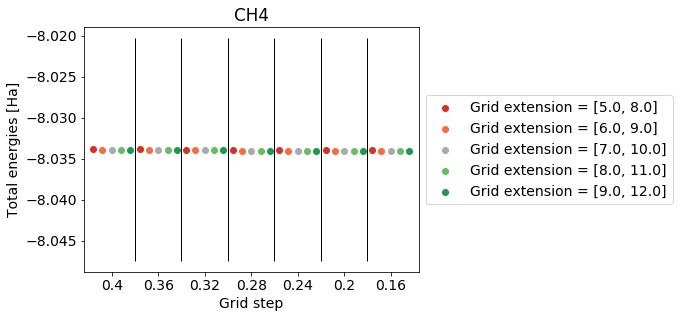

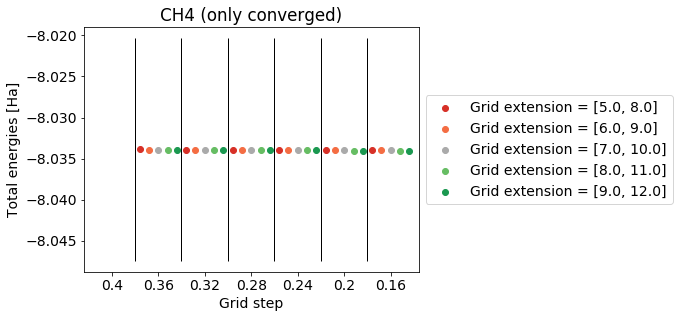

mean = -8.0339758 cm^-1; std. dev. = 4.42e-05 cm^-1; std. dev / mean = -5.502e-06
mean = -8.0338625 cm^-1; std. dev. = 3.10e-05 cm^-1; std. dev / mean = -3.865e-06


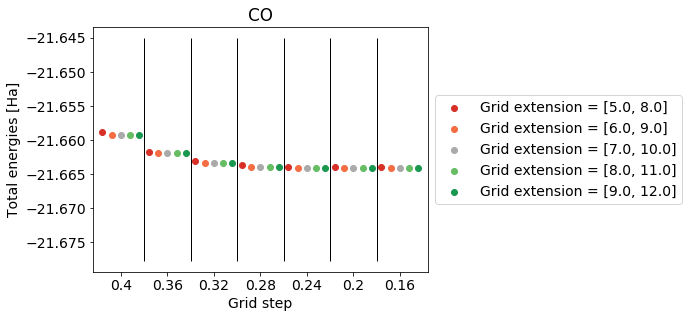

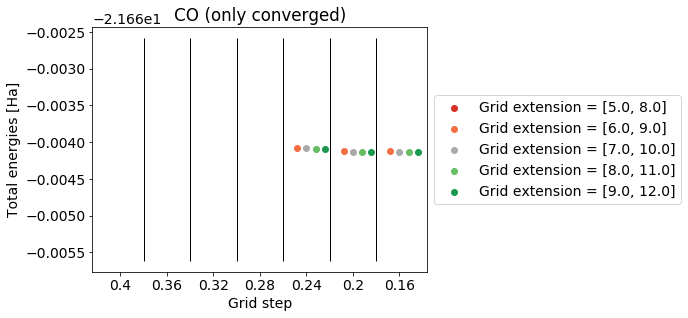

mean = -21.6641157 cm^-1; std. dev. = 2.44e-05 cm^-1; std. dev / mean = -1.126e-06
mean = -21.6622731 cm^-1; std. dev. = 1.82e-03 cm^-1; std. dev / mean = -8.402e-05


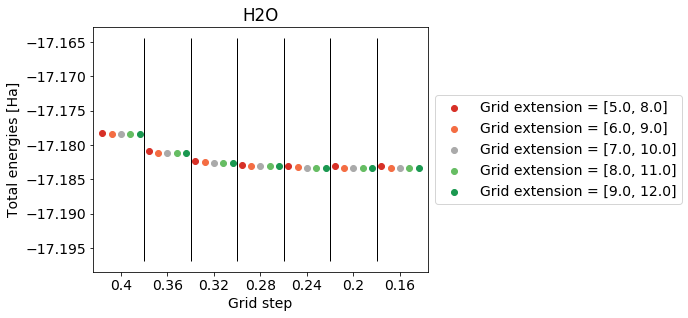

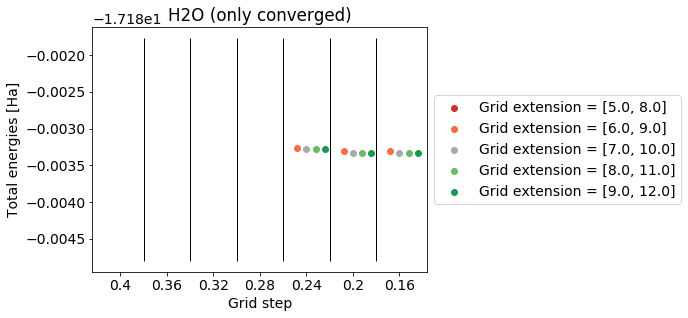

mean = -17.1833093 cm^-1; std. dev. = 2.60e-05 cm^-1; std. dev / mean = -1.511e-06
mean = -17.1814955 cm^-1; std. dev. = 1.79e-03 cm^-1; std. dev / mean = -1.043e-04


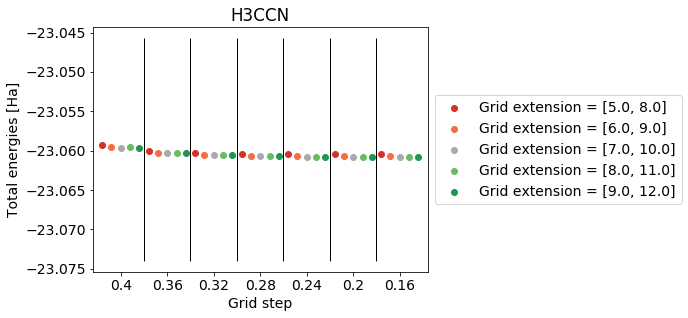

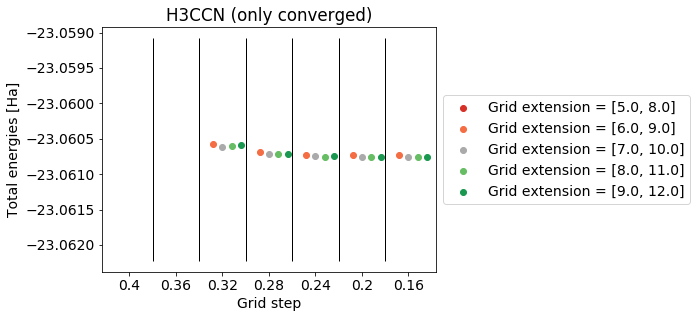

mean = -23.0607101 cm^-1; std. dev. = 6.10e-05 cm^-1; std. dev / mean = -2.646e-06
mean = -23.0600454 cm^-1; std. dev. = 3.92e-04 cm^-1; std. dev / mean = -1.700e-05


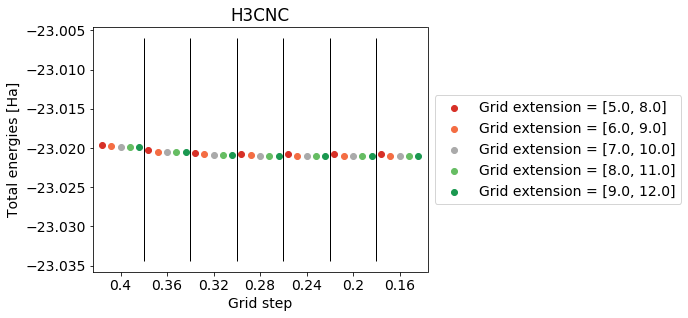

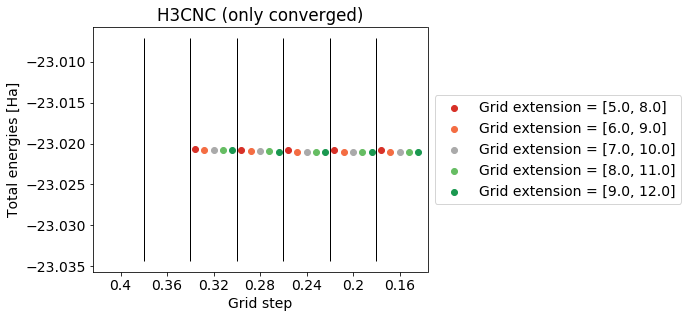

mean = -23.0209258 cm^-1; std. dev. = 1.04e-04 cm^-1; std. dev / mean = -4.523e-06
mean = -23.0201109 cm^-1; std. dev. = 3.57e-04 cm^-1; std. dev / mean = -1.551e-05


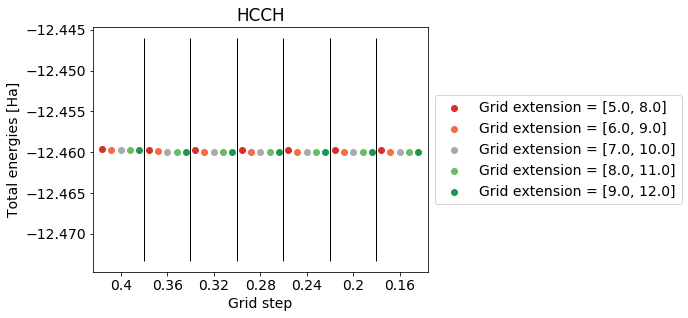

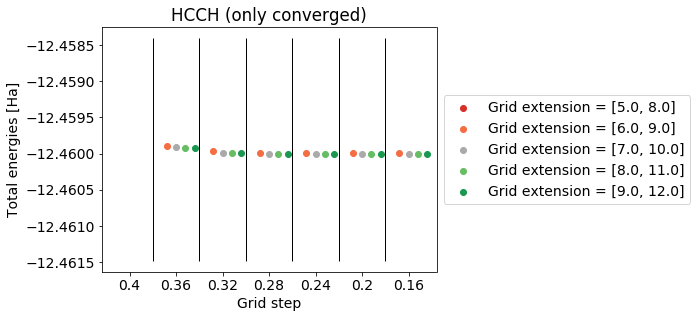

mean = -12.4599843 cm^-1; std. dev. = 3.53e-05 cm^-1; std. dev / mean = -2.830e-06
mean = -12.4597438 cm^-1; std. dev. = 6.70e-05 cm^-1; std. dev / mean = -5.380e-06


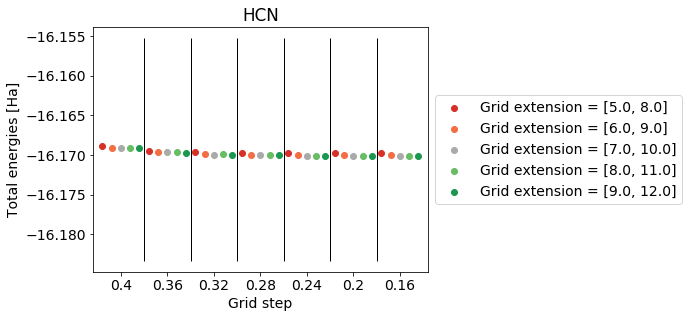

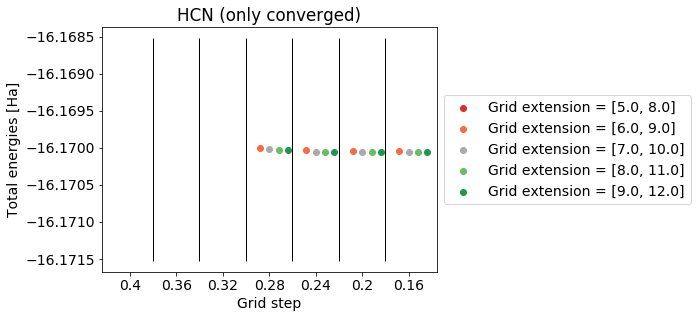

mean = -16.1700447 cm^-1; std. dev. = 1.68e-05 cm^-1; std. dev / mean = -1.040e-06
mean = -16.1695540 cm^-1; std. dev. = 3.48e-04 cm^-1; std. dev / mean = -2.153e-05


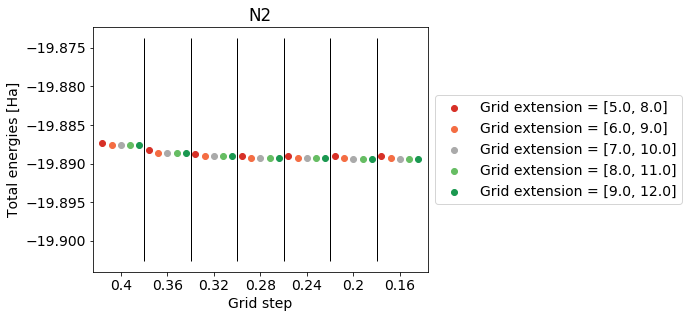

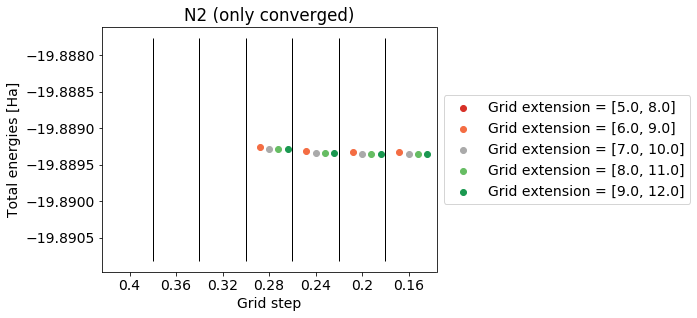

mean = -19.8893219 cm^-1; std. dev. = 3.15e-05 cm^-1; std. dev / mean = -1.585e-06
mean = -19.8885110 cm^-1; std. dev. = 5.99e-04 cm^-1; std. dev / mean = -3.014e-05


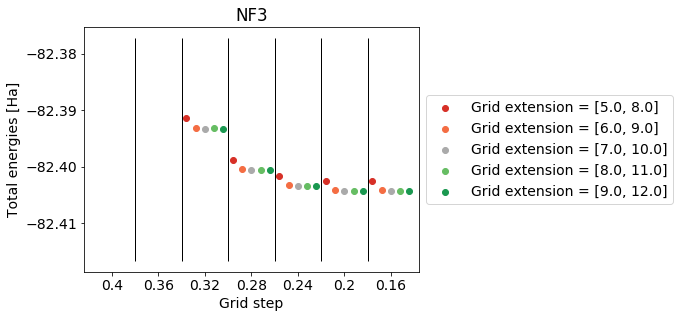

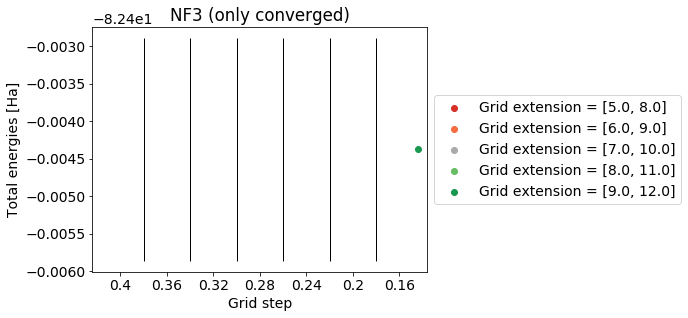

mean = -82.4043773 cm^-1; std. dev. = 0.00e+00 cm^-1; std. dev / mean = -0.000e+00
mean = -82.4006022 cm^-1; std. dev. = 4.29e-03 cm^-1; std. dev / mean = -5.205e-05


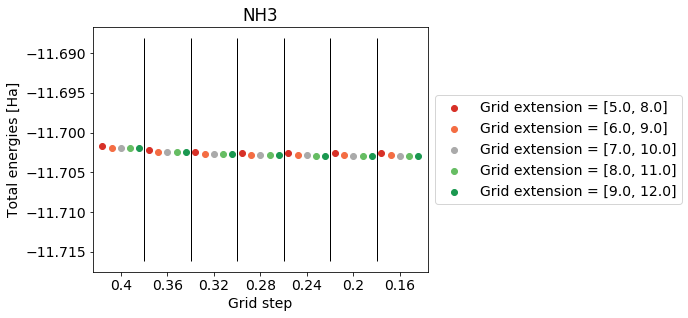

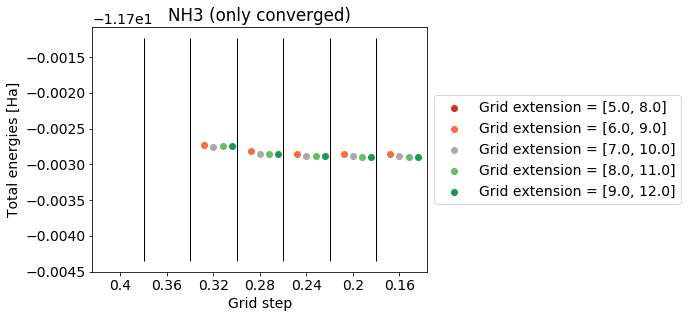

mean = -11.7028459 cm^-1; std. dev. = 5.54e-05 cm^-1; std. dev / mean = -4.736e-06
mean = -11.7022792 cm^-1; std. dev. = 3.18e-04 cm^-1; std. dev / mean = -2.716e-05


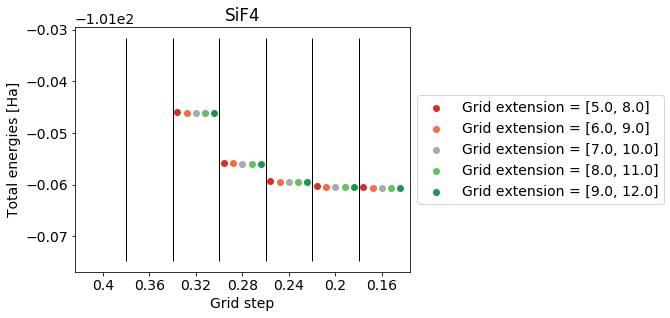

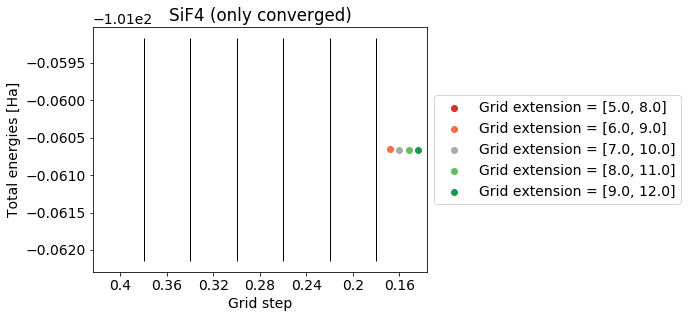

mean = -101.0606625 cm^-1; std. dev. = 2.07e-06 cm^-1; std. dev / mean = -2.047e-08
mean = -101.0557176 cm^-1; std. dev. = 5.65e-03 cm^-1; std. dev / mean = -5.594e-05


In [9]:
for name in MOLECULES:
    plot_total_energies(name)
    plot_total_energies(name, only_converged=True)
    total_energies_stats(name, only_converged=True)
    total_energies_stats(name, only_not_converged=True)

## Precision on the total energy

The output of the above cell shows that statistics such as the mean value and the standard deviation of each total energy can be conveniently accessed. Most importantly, one can easily discriminate converged and non-converged total energies. Let us see how all these values can be used to assess the expected precision on the total energy. This precision should be linked to the precision per atom on the total energy is around 2 meV (or ~ 16 cm$^{-1}$): increasing or decreasing that value should have a similar effect on the errors on the total energy (but that won't be studied).

In order to do that, we need to gather the mean total energy and the standard deviation for each molecule. This is done in the following cell, discriminating the data coming from converged and not converged calculations.

In [10]:
# The stats obtained along with the above plots are stored in the
# following dictionary, which has the molcule names as key. Stats for
# both converged and non-converged stats are computed, except for some
# cases defined above (where the non-converged results cannot be computed).
stats = {}
# Loop over the molecules
for name in MOLECULES:
    stats[name] = {"converged": None, "not_converged": None}
    # Find the converged mean total energy and standard deviation
    mean_c, std_dev_c = total_energies_stats(
        name, only_converged=True, verbosity=False
    )
    stats[name]["converged"] = {"mean": mean_c, "std_dev": std_dev_c}
    # Find the non-converged mean total energy and standard deviation
    mean_nc, std_dev_nc = total_energies_stats(
        name, only_not_converged=True, verbosity=False
    )
    stats[name]["not_converged"] = {"mean": mean_nc, "std_dev": std_dev_nc}
    # It is expected for the converged standard deviation to be larger
    # than the non-converged one
    if std_dev_nc and std_dev_nc < std_dev_c:
        print(
            f"The total energy of molecule {name} "
            f"has a larger standard deviation for converged calculations "
            f"({std_dev_c:.2e} > {std_dev_nc:.2e})"
        )

The total energy of molecule CH4 has a larger standard deviation for converged calculations (4.42e-05 > 3.10e-05)


Only one molecule has a larger standard deviation for the converged total energy than for not converged ones.

We can count the number of supposedly converged total energies below a given limit in order to state which is the expected precision on the total energy (within 3 sigma). This is rather similar to the study performed for the phonon energies.

In [11]:
def nb_under_3_std_dev(precision, only_converged=True,
                       only_not_converged=False):
    """
    Parameters
    ----------
    precision : float
        Precision on the total energy (in Ha).
    
    Returns
    -------
    int
        The number of total energies (supposed to be converged)
        in the test set for which three times the standard
        deviation is below the given precision.
    """
    # Set the key
    if only_converged:
        key = "converged"
    if only_not_converged:
        key = "not_converged"
    # Gather the standard deviations
    std_devs = [value[key]["std_dev"] for value in stats.values()]
    # Return the number of dipoles with a standard deviation
    # below the specified precision
    return sum(3*std_dev <= precision for std_dev in std_devs)

It is now possible to study how many total energies are such that 3 standard deviations are below a given precision as a function of the precision. This will allow us to evaluate the precision on the total energy. This is done by finding the maximum difference between the converged and non-converged results for a given precision.

Precision: 1.92e-04 Ha
Precision: 9.17e-04 Ha


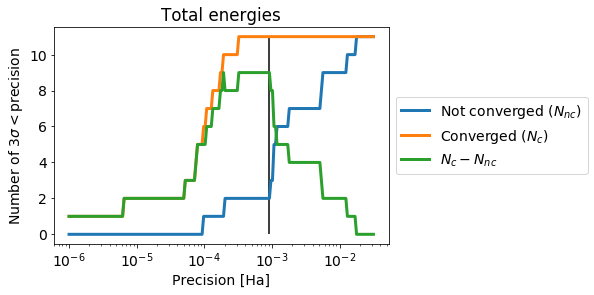

In [12]:
# Define a wide range of precisions
exponents = np.linspace(1.5, 6, 200)
precisions = [10**(-n) for n in exponents]
# Get the number of converged and non-converged dipoles below that
# precision
nb_c = [nb_under_3_std_dev(precision) for precision in precisions]
nb_nc = [
    nb_under_3_std_dev(precision, only_not_converged=True)
    for precision in precisions
]
# Compute the difference between both arrays
diff = np.array(nb_c)-np.array(nb_nc)
# Find the precision, associated with the largest difference
argmax = np.argmax(diff[::-1])
precision = precisions[::-1][argmax]
print(f"Precision: {precision:.2e} Ha")
argmax = np.argmax(diff)
precision = precisions[argmax]
print(f"Precision: {precision:.2e} Ha")
# Plot all the relevant data as a function of the precision
plt.plot(precisions, nb_nc, label=r"Not converged ($N_{nc}$)", lw=3)
plt.plot(precisions, nb_c, label=r"Converged ($N_{c}$)", lw=3)
plt.plot(precisions, diff, label=r"$N_c - N_{nc}$", lw=3)
plt.xscale('log')
plt.title("Total energies")
plt.xlabel(r"Precision [Ha]")
plt.ylabel(r"Number of $3 \sigma < $precision")
plt.vlines(precision, min(nb_nc), max(nb_c))
plt.legend(loc=6, bbox_to_anchor=(1, 0.5))
plt.show()

Given that there are less data to be used (compared to the same study for phonon energies), and also because the total energy depends on the total number of electron in the systems, there are two peaks for the difference between the number of converged and not converged total energies under a given precision. The precision on the total energy might therefore span an order of magnitude, the largest value being 9.17 10$^{-4}$ Ha.

In [27]:
f"Expected precision: {0.002 * EV_TO_HA * 6:.2e}"

'Expected precision: 4.41e-04'

## Plot the dispersion

The above cell shows that statistics such as the mean value and the standard deviation of each total energy can be conveniently accessed. Most importantly, one can easily discriminate converged and non-converged total energies. Let us see how all these values can be used to do some plots, spanning the whole test set.

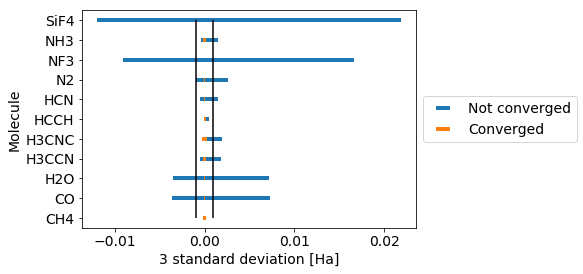

In [13]:
# Loop over the converged and not-converged data to plot the errorbars
for key in ["not_converged", "converged"]:
    x = []  # Center of each error-bar
    x_err = []  # Width of each error bar
    # Loop over the molecules
    for value in stats.values():
        # Define the width of the error-bar
        if not isinstance(value[key]["std_dev"], np.float64):
            x_err.append(0)
        else:    
            x_err.append(3*value[key]["std_dev"])
        # Define the center of the error-bar for non-converged results
        if key == "not_converged":
            converged_mean = value["converged"]["mean"]
            not_converged_mean = value["not_converged"]["mean"]
            if (not isinstance(converged_mean, np.float64) 
                    or not isinstance(not_converged_mean, np.float64)):
                x.append(0)
            else:
                x.append(not_converged_mean - converged_mean)
    # Set the center of the error-bars for converged results as 0
    if key == "converged":
        x = np.zeros_like(x_err)
    # Set the y-axis as an ID of the dipole
    y = np.arange(len(x_err))
    # Plot the error-bars
    label = key.replace("_", " ").capitalize()
    plt.errorbar(x, y, xerr=x_err, linestyle="", elinewidth=4, label=label)
# Finalize the plot
plt.yticks(y, [name for name in stats])
plt.xlabel("3 standard deviation [Ha]")
plt.ylabel("Molecule")
plt.vlines([-precision, precision], min(y), max(y))
plt.legend(loc=6, bbox_to_anchor=(1, 0.5))
plt.show()

This is the same plot as above, except that the y-axis gives the mean dipole for the converged calculations. It seems that large dipoles tend to give larger errors than the smaller ones.

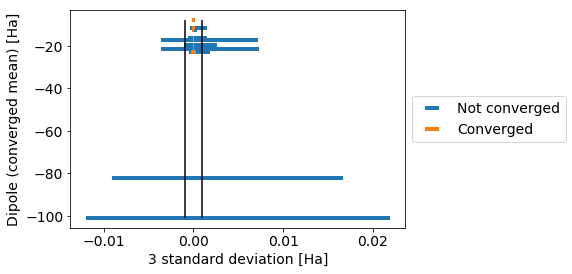

In [14]:
# Loop over the converged and not-converged data to plot the errorbars
for key in ["not_converged", "converged"]:
    x = []  # Center of each error-bar
    y = []  # Mean dipole of the converged calculations
    x_err = []  # Width of each error-bars along the x-axis
    # Loop over the molecules
    for value in stats.values():
        # Define the location on the y-axis
        converged_mean = value["converged"]["mean"]
        y.append(converged_mean)
        # Define the width of the error-bar
        if not isinstance(value[key]["std_dev"], np.float64):
            x_err.append(0)
        else:    
            x_err.append(3*value[key]["std_dev"])
        # Define the center of the error-bar for non-converged results
        if key == "not_converged":
            not_converged_mean = value["not_converged"]["mean"]
            if (not isinstance(converged_mean, np.float64) 
                    or not isinstance(not_converged_mean, np.float64)):
                x.append(0)
            else:
                x.append(not_converged_mean - converged_mean)
    # Set the center of the error-bars for converged results as 0
    if key == "converged":
        x = np.zeros_like(x_err)
    # Plot the error-bars
    label = key.replace("_", " ").capitalize()
    plt.errorbar(x, y, xerr=x_err, linestyle="", elinewidth=4, label=label)
# Finalize the plot
plt.xlabel("3 standard deviation [Ha]")
plt.ylabel("Dipole (converged mean) [Ha]")
plt.legend(loc=6, bbox_to_anchor=(1, 0.5))
plt.vlines([-precision, precision], min(y), max(y))
plt.show()

In [15]:
def weighted_std(values, weights=None):
    """
    Return the weighted standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    if weights is None:
        weights = np.ones_like(values)
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return np.sqrt(variance)

In [16]:
data = c.execute(
    "SELECT value, hgrid, frmult, crmult "
    "FROM total_energies "
    "WHERE molecule = 'HCN'"
).fetchall()

In [17]:
total_energies = [d[0] for d in data]
ref_energy = min(total_energies)
ΔE = np.array([d[0] - ref_energy for d in data])
max_ΔE = max(ΔE)
diff = max_ΔE - ΔE
weights = diff / sum(diff)

In [18]:
np.mean(total_energies), np.average(total_energies), np.average(total_energies, weights=weights)

(-16.169778298132023, -16.169778298132023, -16.169906574120375)

In [19]:
np.std(total_energies), weighted_std(total_energies), weighted_std(total_energies, weights)

(0.0003545068432978913, 0.0003545068432978913, 0.00021852398421553905)

In [20]:
from mybigdft.globals import EV_TO_HA
δE_ref = 0.002 * EV_TO_HA * 3
for (energy, hg, frm, crm) in data:
    diff = energy - ref_energy
    if diff < δE_ref:
        print(f"{hg}, [{frm:.0f}, {crm:.0f}]: converged")
    else:
        print(f"{hg}, [{frm:.0f}, {crm:.0f}]: not converged")

0.4, [5, 8]: not converged
0.4, [6, 9]: not converged
0.4, [7, 10]: not converged
0.4, [8, 11]: not converged
0.4, [9, 12]: not converged
0.36, [5, 8]: not converged
0.36, [6, 9]: not converged
0.36, [7, 10]: not converged
0.36, [8, 11]: not converged
0.36, [9, 12]: not converged
0.32, [5, 8]: not converged
0.32, [6, 9]: converged
0.32, [7, 10]: converged
0.32, [8, 11]: converged
0.32, [9, 12]: converged
0.28, [5, 8]: not converged
0.28, [6, 9]: converged
0.28, [7, 10]: converged
0.28, [8, 11]: converged
0.28, [9, 12]: converged
0.24, [5, 8]: not converged
0.24, [6, 9]: converged
0.24, [7, 10]: converged
0.24, [8, 11]: converged
0.24, [9, 12]: converged
0.2, [5, 8]: not converged
0.2, [6, 9]: converged
0.2, [7, 10]: converged
0.2, [8, 11]: converged
0.2, [9, 12]: converged
0.16, [5, 8]: not converged
0.16, [6, 9]: converged
0.16, [7, 10]: converged
0.16, [8, 11]: converged
0.16, [9, 12]: converged
